In [14]:
import torch
print('Torch:', torch.__version__)
print('CUDA build:', getattr(torch.version, 'cuda', None))
print('CUDA available:', torch.cuda.is_available())
print('Device count:', torch.cuda.device_count())
if torch.cuda.is_available():
    print('Device 0:', torch.cuda.get_device_name(0))

Torch: 2.8.0+cpu
CUDA build: None
CUDA available: False
Device count: 0


In [3]:
import sys, os, subprocess
print('Notebook Python:', sys.executable)
print('Before torch version check...')
try:
    import torch
    print('Existing torch:', torch.__version__, 'CUDA?', torch.cuda.is_available())
except Exception as e:
    print('Torch not importable:', e)

# Install CUDA wheel into this exact kernel env
cmd = [sys.executable, '-m', 'pip', 'install', '--index-url', 'https://download.pytorch.org/whl/cu121', 'torch', 'torchvision', 'torchaudio', '--force-reinstall']
print('Running:', ' '.join(cmd))
proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
print(proc.stdout)

import importlib
importlib.invalidate_caches()
import torch
print('After install torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))

Notebook Python: c:\Program Files\Python39\python.exe
Before torch version check...
Existing torch: 2.8.0+cpu CUDA? False
Running: c:\Program Files\Python39\python.exe -m pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio --force-reinstall
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp39-cp39-win_amd64.whl (2449.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp39-cp39-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp39-cp39-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl (15 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2025.9.0-py3-none-any.whl (199 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.5-py3-no

In [13]:
import os, torch
os.environ['UNET_EPOCHS'] = os.environ.get('UNET_EPOCHS','30')
print('UNET_EPOCHS =', os.environ['UNET_EPOCHS'])
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device count:', torch.cuda.device_count())
    print('CUDA device 0:', torch.cuda.get_device_name(0))

UNET_EPOCHS = 30
CUDA available: False


# Train U-Net for Flood Segmentation (256×256, VV+VH)
This notebook trains a small U-Net on processed Sen1Floods11 tiles, with a synthetic fallback if no data is present. Saves best model to `models/best_unet.pt`.

In [5]:
import os, json, math, random, time
from pathlib import Path
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

ROOT = Path.cwd().parent if Path.cwd().name=='notebooks' else Path.cwd()
PROC = ROOT / 'processed'
MAN = PROC / 'manifests'
MODELS = ROOT / 'models'
MODELS.mkdir(exist_ok=True, parents=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print('Root:', ROOT)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Dataset & transforms

In [4]:
class FloodTiles(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = np.load(r['image_path']).astype('float32')  # (2,H,W)
        msk = np.load(r['mask_path']).astype('float32')   # (H,W)
        if self.augment:
            # simple flips/rotations
            if random.random()<0.5:
                img = img[:, :, ::-1]; msk = msk[:, ::-1]
            if random.random()<0.5:
                img = img[:, ::-1, :]; msk = msk[::-1, :]
        img_t = torch.from_numpy(img)
        msk_t = torch.from_numpy(msk)[None, ...]
        return img_t, msk_t

NameError: name 'Dataset' is not defined

## Model: tiny U-Net (custom, CPU-friendly)

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.seq(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=2, out_ch=1):
        super().__init__()
        self.down1 = DoubleConv(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.bott = DoubleConv(128, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = DoubleConv(64, 32)
        self.outc = nn.Conv2d(32, out_ch, 1)
    def forward(self, x):
        d1 = self.down1(x); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        d3 = self.down3(p2); p3 = self.pool3(d3)
        b = self.bott(p3)
        u3 = self.up3(b); c3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(c3); c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2); c1 = self.conv1(torch.cat([u1, d1], dim=1))
        return self.outc(c1)

## Loss, metrics, and helpers

In [4]:
bce = nn.BCEWithLogitsLoss()
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter + smooth) / (union + smooth)
    return 1 - dice.mean()

def loss_fn(pred, target):
    return bce(pred, target) + dice_loss(pred, target)

def iou_score(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - inter
    return ((inter + eps) / (union + eps)).mean().item()

## Build DataLoaders (with synthetic fallback)

In [7]:
def build_dataloaders(batch=8):
    man_train = MAN / 'train.csv'; man_val = MAN / 'val.csv'
    if man_train.exists() and man_val.exists():
        train_df = pd.read_csv(man_train)
        val_df = pd.read_csv(man_val)
    else:
        train_df = pd.DataFrame(); val_df = pd.DataFrame()
    # If empty, generate small synthetic dataset
    if len(train_df)==0 or len(val_df)==0:
        print('No manifests found or empty → using synthetic fallback')
        def synth(n=64, size=256):
            imgs, msks = [], []
            for _ in range(n):
                img = np.random.rand(2, size, size).astype('float32')*0.1
                msk = np.zeros((size, size), dtype='float32')
                # draw random circle mask
                cx, cy = np.random.randint(64, size-64, 2)
                rr, cc = np.ogrid[:size, :size]
                rad = np.random.randint(20, 60)
                circle = (rr-cy)**2 + (cc-cx)**2 <= rad*rad
                msk[circle] = 1.0
                # add signal inside mask
                img[0][circle] += 0.8; img[1][circle] += 0.6
                imgs.append(img); msks.append(msk)
            return np.array(imgs), np.array(msks)
        Xtr, Ytr = synth(96); Xv, Yv = synth(24)
        class DS(Dataset):
            def __init__(self, X, Y, aug=False): self.X, self.Y, self.aug = X, Y, aug
            def __len__(self): return len(self.X)
            def __getitem__(self, i):
                x, y = self.X[i], self.Y[i]
                if self.aug and random.random()<0.5:
                    x = x[:, :, ::-1].copy(); y = y[:, ::-1].copy()
                return torch.from_numpy(x), torch.from_numpy(y)[None, ...]
        train_ds = DS(Xtr, Ytr, aug=True); val_ds = DS(Xv, Yv, aug=False)
    else:
        train_ds = FloodTiles(train_df, augment=True)
        val_ds = FloodTiles(val_df, augment=False)
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, num_workers=0)
    return train_loader, val_loader

train_loader, val_loader = build_dataloaders(batch=8)
len(train_loader.dataset), len(val_loader.dataset)

No manifests found or empty → using synthetic fallback


(96, 24)

## Train loop (save best by Val IoU)

In [ ]:
model = UNetSmall(in_ch=2, out_ch=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
best_iou = -1.0
best_path = MODELS / 'best_unet.pt'
EPOCHS = int(os.getenv("UNET_EPOCHS", "30"))  # configurable epochs for better IoU
for ep in range(1, EPOCHS+1):
    model.train(); tr_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        p = model(x)
        loss = loss_fn(p, y)
        loss.backward(); optimizer.step()
        tr_loss += loss.item()
    # val
    model.eval(); val_iou = 0.0; n=0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            p = model(x)
            val_iou += iou_score(p, y)
            n += 1
    val_iou /= max(1,n)
    print(f'Epoch {ep:02d} | TrainLoss {(tr_loss/len(train_loader)):.3f} | ValIoU {val_iou:.3f}')
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), best_path)
print('Saved best to', best_path, 'ValIoU=', best_iou)

Epoch 01 | TrainLoss 1.248 | ValIoU 0.994
Epoch 02 | TrainLoss 1.109 | ValIoU 0.976
Epoch 03 | TrainLoss 1.057 | ValIoU 0.951
Epoch 04 | TrainLoss 0.988 | ValIoU 0.956
Epoch 05 | TrainLoss 0.882 | ValIoU 0.984
Saved best to c:\workspace\yes-scan-apex\yes_scan_prototype\models\best_unet.pt ValIoU= 0.9940417806307474


## Quick prediction preview

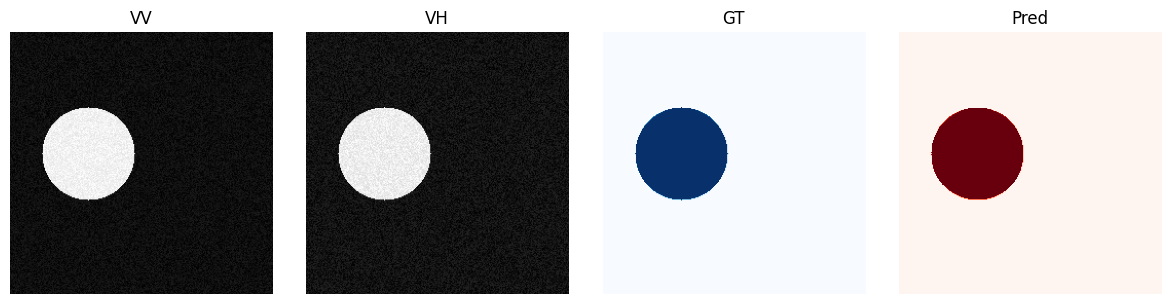

In [9]:
# Load best and visualize one batch
best = UNetSmall(in_ch=2, out_ch=1).to(device)
best.load_state_dict(torch.load(MODELS / 'best_unet.pt', map_location=device))
best.eval()
x, y = next(iter(val_loader))
x, y = x.to(device), y.to(device)
with torch.no_grad(): p = best(x)
pr = (torch.sigmoid(p)>0.5).float()
x0 = x[0,0].cpu().numpy(); x1 = x[0,1].cpu().numpy(); gt = y[0,0].cpu().numpy(); pm = pr[0,0].cpu().numpy()
fig,axs = plt.subplots(1,4, figsize=(12,3))
axs[0].imshow(x0, cmap='gray'); axs[0].set_title('VV')
axs[1].imshow(x1, cmap='gray'); axs[1].set_title('VH')
axs[2].imshow(gt, cmap='Blues'); axs[2].set_title('GT')
axs[3].imshow(pm, cmap='Reds'); axs[3].set_title('Pred')
[a.axis('off') for a in axs]; plt.tight_layout(); plt.show()